TASK 7: Stock Market Prediction using Numerical and Textual Analysis
Importing all the required packages for this task

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
import time
import warnings
warnings.filterwarnings("ignore")
plt.style.use(style="seaborn")
%matplotlib inline
import itertools
import nltk
import re
from sklearn.preprocessing  import MinMaxScaler
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

[nltk_data] Downloading package stopwords to C:\Users\Kankana
[nltk_data]     Ghosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Kankana
[nltk_data]     Ghosh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
#Importing the stock dataset
df=pd.read_csv("C:/Users/Kankana Ghosh/Desktop/BESEN.csv",index_col='Date',parse_dates=True)
print(df.shape)
df.head(5)

(735, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-10,"34,538.78","34,565.63","34,311.63",34433.07,"34,433.07","8,500"
2018-01-11,"34,471.48","34,558.88","34,400.61",34503.49,"34,503.49","8,100"
2018-01-12,"34,578.99","34,638.42","34,342.16",34592.39,"34,592.39","7,800"
2018-01-15,"34,687.21","34,963.69","34,687.21",34843.51,"34,843.51","14,600"
2018-01-16,"34,877.71","34,936.03","34,735.55",34771.05,"34,771.05","53,600"


In [3]:
#Creating a dataset containing the Close column of the above dataset
df=df[["Close"]].copy()
df['Close']=pd.to_numeric(df['Close'])
df.describe()

,Close
count,735.000000
mean,37348.259061
std,3455.256729
min,25981.240000
25%,35203.970000
50%,37318.530000
75%,39127.000000
max,48782.510000


<AxesSubplot:xlabel='Date'>

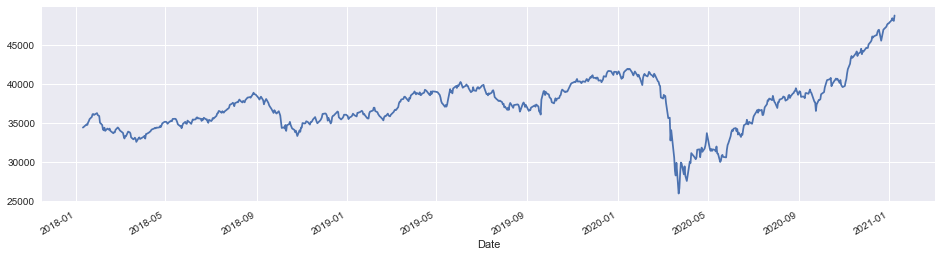

In [4]:
#Ploting the Close column to see the trend
df.index=df.index[0:len(df)]
df['Close'].plot(figsize=(16,4))

Fitting an ARIMA Model to the dataset

In [ ]:
#Checking if the series is stationary
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
    result=adfuller(dataset,autolag='AIC')
    print(f"ADF Statistic:{result[0]}")
    print(f"P-Value:{result[1]}")
    print(f"Num of Lags:{result[2]}")
    print(f"Num of observations used for ADF regression and critical value calculation:{result[3]}")
    print(f"Critical Values:")
    for key,val in result[4].items():
        print("\t",key,":",val)

In [6]:
ad_test(df['Close'])

ADF Statistic:-1.188202480977596
P-Value:0.6786500062031668
Num of Lags:10
Num of observations used for ADF regression and critical value calculation:724
Critical Values:
	 1% : -3.4394144152232995
	 5% : -2.8655403100177566
	 10% : -2.5689002207655443


Let us consider H0: The dataset is not stationary against H1: The dataset is stationary.

Here, we see that the P-Value is greater than 0.05 so the null hypothesis is accepted and hence we conclude that the dataset is not sationary.

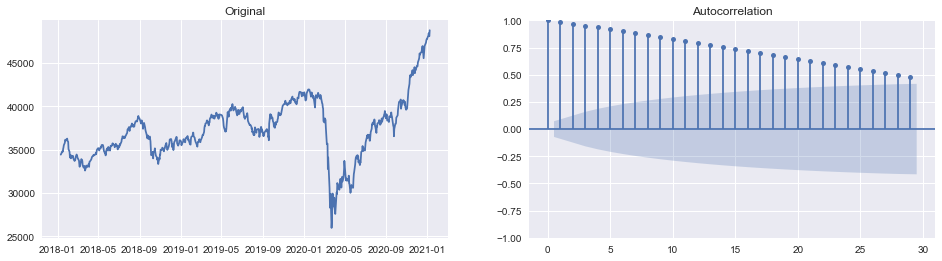

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(df.Close)
ax1.set_title("Original")
plot_acf(df.Close,ax=ax2);

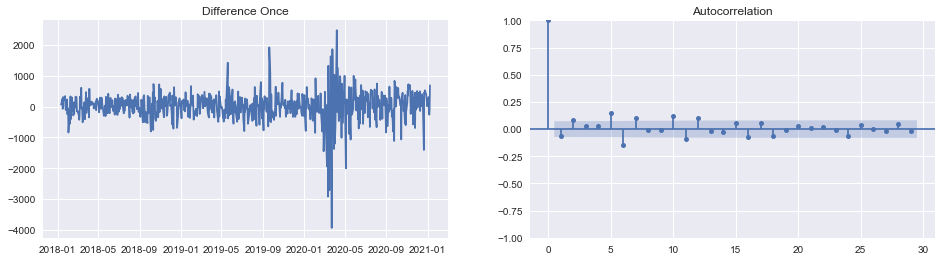

In [8]:
#Calculating the d, i.e., the order of difference,the number of nonseasonal differences needed for stationarity
diff=df.Close.diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
plot_acf(diff,ax=ax2);

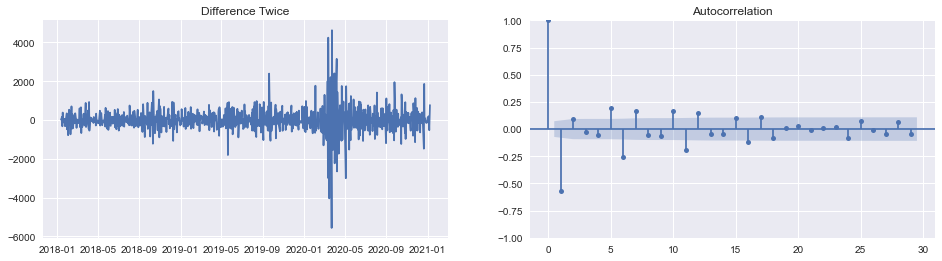

In [9]:
diff=df.Close.diff().diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Twice")
plot_acf(diff,ax=ax2);

Here, we see that when d=2 the negative magnitude of the autocorrelation increases.Hence,we stop the difference calculation at 
second order and the value of d=1


In [10]:
#We can also find the value of d using pmdarima package
from pmdarima.arima.utils import ndiffs
ndiffs(df.Close,test="adf")

1

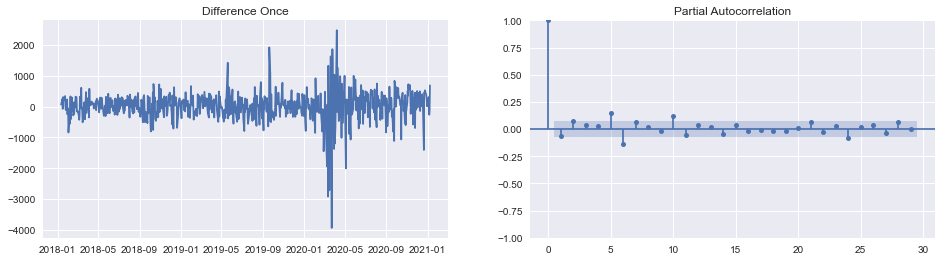

In [11]:
#Calculating the of p,i.e.,is the number of autoregressive terms.
from statsmodels.graphics.tsaplots import plot_pacf
diff=df.Close.diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
ax2.set_ylim(0,1)
plot_pacf(diff,ax=ax2);

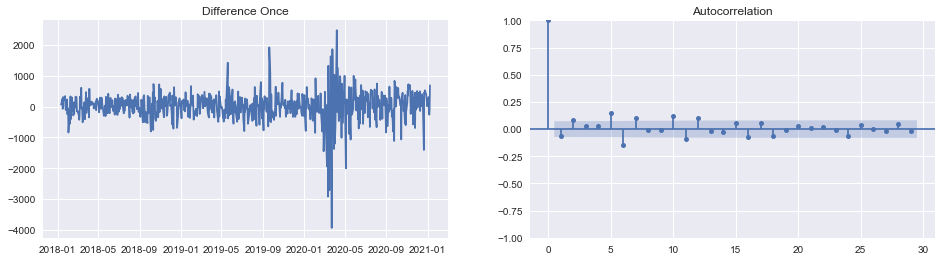

In [12]:
#Calculating the value of q,i.e.,the number of lagged forecast errors in the prediction equation.
diff=df.Close.diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference Once")
ax2.set_ylim(0,1)
plot_acf(diff,ax=ax2);

In [13]:
#We can also calculate the value of p,q,d using pmdarima package
from pmdarima import auto_arima
stepwise_fit=auto_arima(df['Close'],trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11086.650, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11089.649, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11089.305, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11089.597, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11088.970, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11084.845, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11087.287, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11090.106, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11086.870, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11088.916, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11084.675, Time=0.49 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11087.337, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11089.221, Time=0.32 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11088.062, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0

In [14]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  735
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -5537.701
Date:                Thu, 12 Jan 2023   AIC                          11083.402
Time:                        12:34:38   BIC                          11101.796
Sample:                             0   HQIC                         11090.497
                                - 735                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7223      0.085      8.454      0.000       0.555       0.890
ar.L2          0.1019      0.019      5.308      0.000       0.064       0.140
ma.L1         -0.7766      0.082     -9.494      0.000      -0.937      -0.616
sigma2      2.111e+05   4954.394     42.600      0.000    2.01e+05    2.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):              3743.71
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               5.41   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
#Fitting the ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
#ARIMA Model
warnings.filterwarnings("ignore")
model=ARIMA(df.Close,order=(2,1,1))
result=model.fit()

In [16]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  735
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -5537.701
Date:                Thu, 12 Jan 2023   AIC                          11083.402
Time:                        12:34:38   BIC                          11101.796
Sample:                             0   HQIC                         11090.497
                                - 735                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7223      0.085      8.454      0.000       0.555       0.890
ar.L2          0.1019      0.019      5.308      0.000       0.064       0.140
ma.L1         -0.7766      0.082     -9.494      0.0

(array([1.94365379e-04, 6.83679326e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.57947291e-07]),
 array([-3576.5546657 ,   224.40780087,  4025.37026744,  7826.33273401,
        11627.29520058, 15428.25766715, 19229.22013372, 23030.18260029,
        26831.14506686, 30632.10753343, 34433.07      ]),
 <BarContainer object of 10 artists>)

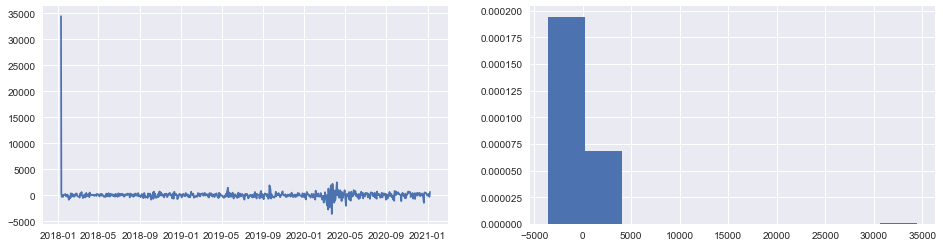

In [17]:
#Plot residual errors
residuals=pd.DataFrame(result.resid)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(residuals)
ax2.hist(residuals,density=True)

In [18]:
from statsmodels.tsa.arima_model import ARIMA
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(735, 1)
(705, 1) (30, 1)


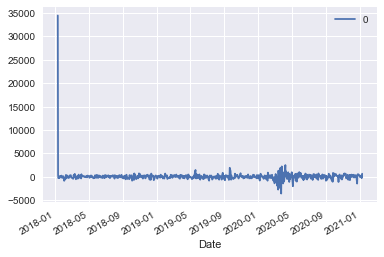

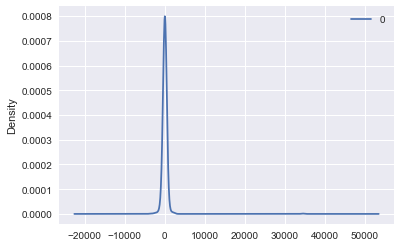

                  0
count    735.000000
mean      60.580750
std     1349.391284
min    -3576.554666
25%     -197.054677
50%       24.118160
75%      242.851327
max    34433.070000


In [19]:
residuals = pd.DataFrame(result.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [20]:
#Actual vs Fitted
result.index=df.index[-30:]
result.predict(start=1,end=30,dynamic=False)

Date
2018-01-11    34131.880084
2018-01-12    34885.767270
2018-01-15    34889.490381
2018-01-16    35069.463910
2018-01-17    34975.284673
2018-01-18    35216.331306
2018-01-19    35386.777913
2018-01-22    35614.423820
2018-01-23    35887.996231
2018-01-24    36220.533635
2018-01-25    36257.874330
2018-01-29    36133.413365
2018-01-30    36323.711431
2018-01-31    36102.435136
2018-02-01    35996.675714
2018-02-02    35927.411352
2018-02-05    35122.551187
2018-02-06    34731.703764
2018-02-07    34175.106775
2018-02-08    34015.475971
2018-02-09    34331.446238
2018-02-12    33998.119180
2018-02-14    34236.994548
2018-02-15    34144.546368
2018-02-16    34266.192311
2018-02-19    34016.473453
2018-02-20    33762.701254
2018-02-21    33674.097863
2018-02-22    33807.034707
2018-02-23    33805.901667
Name: predicted_mean, dtype: float64

In [21]:
#Dividing the dataset into train and test
from statsmodels.tsa.arima.model import ARIMA
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(735, 1)
(705, 1) (30, 1)


In [22]:
start=len(train)
end=len(train)+len(test)-1
pred=result.predict(start=start,end=end,dynamic=False)
pred.index=df.index[start:end+1]
print(pred)

Date
2020-11-26    43923.168022
2020-11-27    44239.283386
2020-12-01    44183.809292
2020-12-02    44643.220448
2020-12-03    44662.131644
2020-12-04    44662.286901
2020-12-07    45079.772630
2020-12-08    45453.818635
2020-12-09    45654.910590
2020-12-10    46131.144433
2020-12-11    46039.609410
2020-12-14    46138.730923
2020-12-15    46290.098051
2020-12-16    46306.840278
2020-12-17    46679.451635
2020-12-18    46929.373096
2020-12-21    47010.002500
2020-12-22    45675.867592
2020-12-23    45933.375039
2020-12-24    46409.616888
2020-12-28    46962.527407
2020-12-29    47378.496627
2020-12-30    47656.963530
2020-12-31    47799.501154
2021-01-01    47806.003641
2021-01-04    47905.569426
2021-01-05    48200.482691
2021-01-06    48473.368658
2021-01-07    48242.631828
2021-01-08    48124.080708
Name: predicted_mean, dtype: float64


<AxesSubplot:xlabel='Date'>

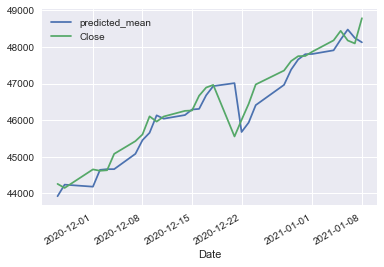

In [23]:
#Plotting the test data
pred.plot(legend=True)
test.index=df.index[-30:]
test['Close'].plot(legend=True)

In [24]:
test['Close'].mean()

46486.77766666667

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['Close']))
print(rmse)

399.69334047349656


Here, we can conclude that the ARIMA Model is quite a good fit because the rmse is quite low compared to the mean.

In [26]:
model2=ARIMA(df['Close'],order=(2,1,1))
model2=model2.fit()
df.head()

,Close
Date,
2018-01-10,34433.07
2018-01-11,34503.49
2018-01-12,34592.39
2018-01-15,34843.51
2018-01-16,34771.05


In [27]:
#Predicting the stocks of the next four months using the previous data by ARIMA Model.
index_future_dates=pd.date_range(start='2021-01-11',end='2021-05-31')
pred=model2.predict(start=len(df),end=len(df)+140,dynamic=False).rename('ARIMA Predictions')
pred.index=index_future_dates

<AxesSubplot:>

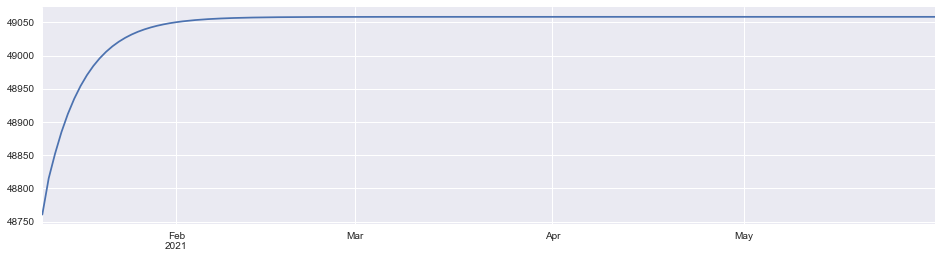

In [28]:
pred.plot(figsize=(16,4))

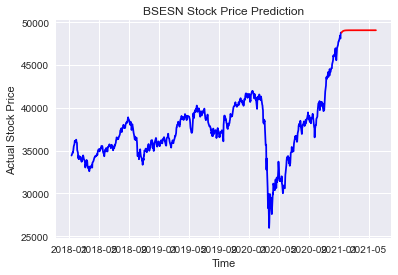

In [29]:
plt.plot(train, label='Train',color="blue")
plt.plot(test, label='Test',color="blue")
plt.plot(pred, label='Prediction',color="red")
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
     
figsize=(16,4)

Here, the red line is the prediction for the four months that comes roughly between 48750 to 49050.

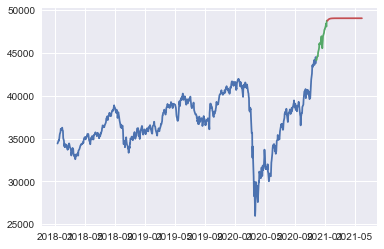

In [30]:
#Here, we plot the train,test and prediction using different colours to differentiate.
plt.plot(train)
plt.plot(test)
plt.plot(pred)

In [31]:
#Importing the textual data.
cols = ['Date','Category','News']
df_news = pd.read_csv("C:/Users/Kankana Ghosh/Desktop/india-news-headlines.csv", names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
3650966,20220331,city.srinagar,J&K sacks 2 cops; 3 other employees over terro...
3650967,20220331,entertainment.hindi.bollywood,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,20220331,city.trichy,As Covid-19 cases drop to nil in southern dist...
3650969,20220331,city.erode,Tamil Nadu sees marginal rise of Covid cases w...


In [32]:
#Cleaning the data
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 1 to 3650970
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    object
 1   News    object
dtypes: object(2)
memory usage: 55.7+ MB


In [33]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
3650966,2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
3650967,2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650968,2022-03-31,As Covid-19 cases drop to nil in southern dist...
3650969,2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


In [34]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...
7713,2022-03-28,As fashion becomes democratic; demand for styl...
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...
7715,2022-03-30,I will not give in to trends: Dossmode The tim...


In [35]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
7712    Playing a dead man in Body God meant sitting i...
7713    As fashion becomes democratic; demand for styl...
7714    Bobby Deol: Like my dad; I hope to be working ...
7715    I will not give in to trends: Dossmode The tim...
7716    Shashank goes back to coastal Karnataka and Mo...
Name: News, Length: 7717, dtype: object

In [36]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [37]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.369592,0.025109
7713,2022-03-28,As fashion becomes democratic; demand for styl...,0.389939,0.055878
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...,0.404240,0.095198
7715,2022-03-30,I will not give in to trends: Dossmode The tim...,0.350965,0.037729


<AxesSubplot:>

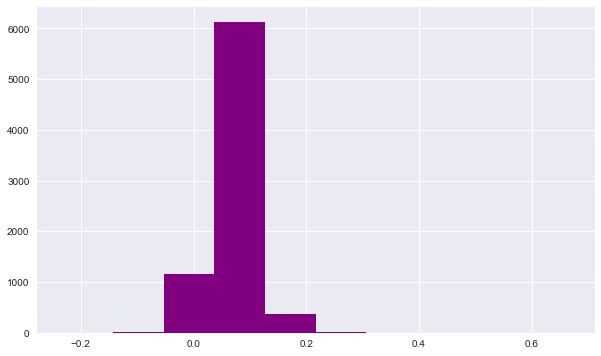

In [38]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

<AxesSubplot:>

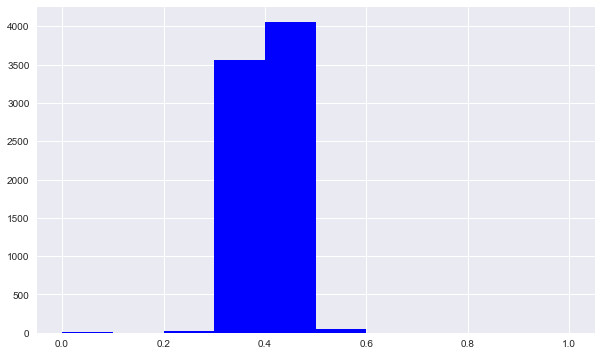

In [39]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [40]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.282333,0.151333,-0.9811,0.122,0.807,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.407692,0.088462,-0.2640,0.122,0.766,0.111
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.446847,0.087961,0.8738,0.100,0.797,0.103
3,2001-01-05,Light combat craft takes India into club class...,0.476612,0.262024,0.9769,0.124,0.719,0.157
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.4215,0.152,0.704,0.143
...,...,...,...,...,...,...,...,...
7712,2022-03-27,Playing a dead man in Body God meant sitting i...,0.369592,0.025109,-0.9999,0.154,0.764,0.082
7713,2022-03-28,As fashion becomes democratic; demand for styl...,0.389939,0.055878,-0.9999,0.158,0.742,0.100
7714,2022-03-29,Bobby Deol: Like my dad; I hope to be working ...,0.404240,0.095198,-0.9999,0.152,0.766,0.082
7715,2022-03-30,I will not give in to trends: Dossmode The tim...,0.350965,0.037729,-0.9999,0.151,0.775,0.074


In [43]:
#Merging the numerical and textual data
df_merge = pd.merge(df, df_news, how='inner', on='Date')
df_merge

,Date,Close,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2018-01-10,34433.07,Coaching classes fume over proposed Act to reg...,0.385999,0.046321,-1.0000,0.159,0.761,0.080
1,2018-01-11,34503.49,Rajini mandrams in Madurai raring to get to wo...,0.364719,0.035556,-1.0000,0.172,0.731,0.097
2,2018-01-12,34592.39,Learn the right way to apply a highlighter Ant...,0.395696,0.042553,-1.0000,0.164,0.742,0.094
3,2018-01-15,34843.51,gst did the government buy more systemic risk ...,0.400246,0.066456,-0.9999,0.153,0.739,0.108
4,2018-01-16,34771.05,Gangasagar event logs record dips this year Th...,0.367151,0.041741,-1.0000,0.172,0.740,0.089
...,...,...,...,...,...,...,...,...,...
730,2021-01-04,48176.80,Micro review: 'Ahalya's Awakening' by Kavita K...,0.400073,0.047840,-0.9999,0.143,0.789,0.069
731,2021-01-05,48437.78,Numerology Readings 05 January 2021: Predictio...,0.417821,0.071803,-0.9999,0.151,0.749,0.100
732,2021-01-06,48174.06,Will UP go for pro-tem chairmanin legislative ...,0.393074,0.043358,-0.9999,0.150,0.771,0.079
733,2021-01-07,48093.32,Chasing the winter sun in Abu Dhabi Know why s...,0.393661,0.036845,-0.9999,0.129,0.802,0.069


In [44]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,34433.07,0.385999,0.046321,-1.0000,0.159,0.761,0.080
1,34503.49,0.364719,0.035556,-1.0000,0.172,0.731,0.097
2,34592.39,0.395696,0.042553,-1.0000,0.164,0.742,0.094
3,34843.51,0.400246,0.066456,-0.9999,0.153,0.739,0.108
4,34771.05,0.367151,0.041741,-1.0000,0.172,0.740,0.089
...,...,...,...,...,...,...,...
730,48176.80,0.400073,0.047840,-0.9999,0.143,0.789,0.069
731,48437.78,0.417821,0.071803,-0.9999,0.151,0.749,0.100
732,48174.06,0.393074,0.043358,-0.9999,0.150,0.771,0.079
733,48093.32,0.393661,0.036845,-0.9999,0.129,0.802,0.069


In [45]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.370674,0.377688,0.447681,0.00000,0.571429,0.383562,0.3375
1,0.373762,0.204467,0.362239,0.00000,0.674603,0.178082,0.5500
2,0.377661,0.456622,0.417777,0.00000,0.611111,0.253425,0.5125
3,0.388674,0.493662,0.607492,0.00005,0.523810,0.232877,0.6875
4,0.385497,0.224268,0.411331,0.00000,0.674603,0.239726,0.4500


In [46]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [47]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.377688,0.447681,0.00000,0.571429,0.383562,0.3375
1,0.204467,0.362239,0.00000,0.674603,0.178082,0.5500
2,0.456622,0.417777,0.00000,0.611111,0.253425,0.5125
3,0.493662,0.607492,0.00005,0.523810,0.232877,0.6875
4,0.224268,0.411331,0.00000,0.674603,0.239726,0.4500


In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(588, 6)

In [49]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
97,0.296734,0.690708,0.00005,0.587302,0.253425,0.5500
503,0.367155,0.440793,0.00000,0.825397,0.123288,0.4125
644,0.553472,0.776355,0.00005,0.619048,0.253425,0.5000
498,0.295462,0.543283,0.00005,0.619048,0.294521,0.4250
303,0.315457,0.093964,0.00000,0.746032,0.232877,0.3375
572,0.250614,0.577728,0.00010,0.285714,0.684932,0.2375
250,0.505627,0.332856,0.00005,0.777778,0.102740,0.5250
17,0.741960,0.590124,0.00005,0.531746,0.171233,0.7875
597,0.505794,0.264424,0.00005,0.436508,0.609589,0.1250
240,0.551062,0.347653,0.00010,0.325397,0.719178,0.1125


Computing the prediction of the hybrid model by using Random Forest Regressor,Adaboost Forest Regressor, Decision Tree 
Regressor, LightGBM and Xgboost techniques and finding the technique that has the minimum mean squared error.


In [50]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [51]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.4463071  0.49373127 0.40132229 0.44441791 0.61675903 0.52095891
 0.60036083 0.50298567 0.54843511 0.57564383]
196    0.354636
187    0.389621
14     0.437861
31     0.371230
390    0.498617
319    0.553438
299    0.573451
719    0.917015
462    0.649014
27     0.338681
Name: Close, dtype: float64
0.01946292845677726


In [52]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [53]:
print(mean_squared_error(predictions, y_test))

0.023601545545726434


In [54]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [55]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.41939331 0.50893086 0.53964143 0.50764365 0.98488111 0.48829035
 0.51544673 0.67288226 0.60093363 0.62534411]
196    0.354636
187    0.389621
14     0.437861
31     0.371230
390    0.498617
319    0.553438
299    0.573451
719    0.917015
462    0.649014
27     0.338681
Name: Close, dtype: float64
0.037696735255026495


In [56]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor()

In [57]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.02114777644780174


In [58]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [59]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.023020821461831927


Form all the above techniques we find that Xgboost has the minimnum Mean Squared Error.
